## technology competition

The following is a step-by-step walkthrough of the competition algorithm used in CERF.

In [70]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt


## Helper functions

In [74]:
def plot_array(arr, title="", figsize=(8, 5)):
    """Plot 2D array with colorbar."""

    fig = plt.figure(figsize=figsize)

    ax = fig.add_subplot(111)
    ax.set_title(title)

    plt.imshow(arr)

    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])

    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)

    plt.show()


def plot_array_wbar(arr, title=""):
    """Plot 2D array with colorbar."""

    fig = plt.figure(figsize=(8, 5))

    ax = fig.add_subplot(111)
    ax.set_title(title)

    # define the colormap
    cmap = plt.cm.viridis 

    # extract all colors from the .jet map
    cmaplist = [cmap(i) for i in range(cmap.N)]

    # force the first color entry to be grey
    cmaplist[0] = "whitesmoke"

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

    # define the bins and normalize
    bounds = np.unique(arr)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    plt.imshow(arr, cmap=cmap)

    ax.set_aspect('equal')

    cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])

    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)

    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
    cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm,
        spacing='proportional', ticks=bounds, boundaries=bounds, format='%1i')

    plt.show()
    

def load_pickle(file):
    """Load pickled file into object."""
    
    return pickle.load(open(file, "rb"))



def buffer_flat_array(target_index, arr, nrows, ncols, ncells, set_value):
    """Assign a value to the neighboring elements of a 1D array as if they
    were in 2D space. The number of neighbors are based on the `ncells` argument
    which is used to define the window around the target cell to be altered as
    if they were in 2D space.

    :param target_index:                Index of the target element in the 1D array
    :type target_index:                 int

    :param arr:                         A 1D array that has been flattened from a corresponding 2D array
    :type arr:                          ndarray

    :param nrows:                       The number of rows in the parent 2D array
    :type nrows:                        int

    :param ncols:                       The number of columns in the parent 2D array
    :type ncols:                        int

    :param ncells:                      The number of cells for the buffer extending as a radius
    :type ncells:                       int

    :param set_value:                   The value to set for the selected buffer
    :type set_value:                    int; float

    :return:                            [0] Modified 1D array
                                        [1] list of buffered indices

    """
    # list to hold buffer indices for the target grid cell
    buffer_indices = []

    # calculate the number of elements in the 2D grid space
    ngrids = nrows * ncols

    # ensure that the target index is in the grid space
    if 0 <= target_index < ngrids:

        # target cell index bounds for the row
        min_idx = target_index - ncells
        max_idx = target_index + ncells + 1

        # create target row limits
        end_row_idx = target_index + ncols - np.mod(target_index, ncols) - 1
        start_row_idx = end_row_idx - (ncols - 1)

        # do not let the index bleed past the row
        if max_idx > end_row_idx:
            max_idx = end_row_idx + 1

        # do not let the index go negative
        if min_idx < start_row_idx:
            min_idx = start_row_idx

        # initialize above
        min_above = min_idx - ncols
        max_above = max_idx - ncols

        # initialize below
        min_below = min_idx + ncols
        max_below = max_idx + ncols

        # target row assignment
        arr[min_idx: max_idx] = set_value

        # add indices to buffer list
        buffer_indices.extend(list(range(min_idx, max_idx)))

        for _ in range(ncells):

            # above
            if min_above >= 0 and max_above >= 0 and start_row_idx < ngrids:
                arr[min_above: max_above] = set_value

                # add indices to buffer list
                buffer_indices.extend(list(range(min_above, max_above)))

            # advance above to the next row
            min_above -= ncols
            max_above -= ncols

            # below
            if min_below <= ngrids and max_below <= ngrids:
                arr[min_below: max_below] = set_value

                # add indices to buffer list
                buffer_indices.extend(list(range(min_below, max_below)))

            # advance below to the next row
            min_below += ncols
            max_below += ncols

    else:
        raise IndexError(f"Index: '{target_index}' is not in the range of the grid space from 0 to {ngrids - 1}.")

    return arr, buffer_indices



## Set up precalculated run

In [72]:
data_dir = "/Users/d3y010/projects/cerf/code/algorithms/data"

target_region_name = "virginia"
settings_dict = load_pickle(os.path.join(data_dir, "settings_dict.pkl"))
technology_dict = load_pickle(os.path.join(data_dir, "technology_dict.pkl"))
technology_order = load_pickle(os.path.join(data_dir, "technology_order.pkl"))
expansion_dict = load_pickle(os.path.join(data_dir, "expansion_dict.pkl"))
lmp_dict = load_pickle(os.path.join(data_dir, "lmp_flat_dict.pkl"))
nov_dict = load_pickle(os.path.join(data_dir, "nov_flat_dict.pkl"))
ic_dict = load_pickle(os.path.join(data_dir, "ic_flat_dict.pkl"))
nlc_mask = load_pickle(os.path.join(data_dir, "suitable_nlc_region.pkl"))
zones_arr = np.load(os.path.join(data_dir, "zones_flat_arr.npy"))
xcoords = np.load(os.path.join(data_dir, "xcoords_region.npy"))
ycoords = np.load(os.path.join(data_dir, "ycoords_region.npy"))
indices_flat = np.load(os.path.join(data_dir, "indices_flat_region.npy"))
randomize = True
seed_value = 42
verbose = True

# reassign to class variable names for consistency
lmp_flat_dict = lmp_dict
nov_flat_dict = nov_dict
ic_flat_dict = ic_dict
zones_flat_arr = zones_arr


## Describe the data

`settings_dict`:  a dictionary of project level settings

In [4]:
settings_dict

{'run_year': 2030,
 'output_directory': None,
 'randomize': True,
 'seed_value': 0,
 'region_raster_file': '/Users/d3y010/repos/github/cerf/cerf/data/cerf_conus_states_albers_1km.tif',
 'region_abbrev_to_name_file': '/Users/d3y010/repos/github/cerf/cerf/data/region-abbrev_to_region-name.yml',
 'region_name_to_id_file': '/Users/d3y010/repos/github/cerf/cerf/data/region-name_to_region-id.yml'}

technology_dict

`technology_dict`: a dictionary of technology specific settings where the key is the technology id as an integer as provide by the user in the configuration file

In [5]:
# view one technology as an example
technology_dict[0]

{'capacity_factor': 0.5714999999999999,
 'variable_om': 9.65138799225307,
 'heat_rate': 11449.7,
 'fuel_price': 0.0,
 'fuel_esc_rate': 0.0,
 'fuel_co2_content': 0.3036,
 'tech_name': 'biomass_conv_wo_ccs',
 'lifetime': 60.0,
 'carbon_capture_rate': 0.0,
 'unit_size': 80,
 'variable_cost_esc_rate': -0.00398993418629034,
 'discount_rate': 0.05,
 'carbon_esc_rate': 0.0,
 'carbon_tax': 0.0,
 'buffer_in_km': 5,
 'require_pipelines': False,
 'suitability_raster_file': None}

`technology_order`:  a list containing the order of technology ids to process; generated from the order in which the technologies are listed in the configuration file

In [6]:
technology_order

[0, 2, 4, 8, 9, 13, 14, 15, 16, 17, 18]

`expansion_dict`:  a dictionary containing the expected number of power plants to be sited for each technology where the key is the technology id

In [7]:
expansion_dict

{0: {'tech_name': 'biomass_conv_wo_ccs', 'n_sites': 0},
 2: {'tech_name': 'biomass_igcc_wo_ccs', 'n_sites': 0},
 4: {'tech_name': 'coal_conv_pul_wo_ccs', 'n_sites': 4},
 9: {'tech_name': 'gas_cc_w_ccs', 'n_sites': 22},
 8: {'tech_name': 'gas_cc_wo_ccs', 'n_sites': 8},
 13: {'tech_name': 'nuclear_gen_ii', 'n_sites': 2},
 14: {'tech_name': 'nuclear_gen_iii', 'n_sites': 0},
 15: {'tech_name': 'oil_ct_wo_ccs', 'n_sites': 2},
 16: {'tech_name': 'solar_csp', 'n_sites': 0},
 17: {'tech_name': 'solar_pv_non_dist', 'n_sites': 11},
 18: {'tech_name': 'wind_onshore', 'n_sites': 0}}

`lmp_dict`: a dictionary of flattend (1D) numpy arrays containing the calculated LMP for each grid cell per technology where the technology id is the key

In [8]:
lmp_dict

{0: array([142.82080974, 142.82080974, 142.82080974, ...,  74.91032851,
         74.91032851,  74.91032851]),
 2: array([145.05844871, 145.05844871, 145.05844871, ...,  77.243453  ,
         77.243453  ,  77.243453  ]),
 4: array([160.5936343 , 160.5936343 , 160.5936343 , ...,  93.32705964,
         93.32705964,  93.32705964]),
 8: array([286.27493385, 286.27493385, 286.27493385, ..., 219.67758775,
        219.67758775, 219.67758775]),
 9: array([168.04431526, 168.04431526, 168.04431526, ..., 100.86960694,
        100.86960694, 100.86960694]),
 13: array([181.53521017, 181.53521017, 181.53521017, ..., 114.29530781,
        114.29530781, 114.29530781]),
 14: array([181.53521017, 181.53521017, 181.53521017, ..., 114.29530781,
        114.29530781, 114.29530781]),
 15: array([452.24301268, 452.24301268, 452.24301268, ..., 383.85869263,
        383.85869263, 383.85869263]),
 16: array([295.48121612, 295.48121612, 295.48121612, ..., 228.89096447,
        228.89096447, 228.89096447]),
 17: a

`nov_dict`: a dictionary of flattend (1D) numpy arrays containing the calculated NOV for each grid cell per technology where the technology id is the key

In [9]:
nov_dict

{0: array([53592245.07574421, 53592245.07574421, 53592245.07574421, ...,
        26393608.38512888, 26393608.38512888, 26393608.38512888]),
 2: array([2.75218731e+08, 2.75218731e+08, 2.75218731e+08, ...,
        1.34545474e+08, 1.34545474e+08, 1.34545474e+08]),
 4: array([6.12325753e+08, 6.12325753e+08, 6.12325753e+08, ...,
        3.11892833e+08, 3.11892833e+08, 3.11892833e+08]),
 8: array([1.49833125e+10, 1.49833125e+10, 1.49833125e+10, ...,
        1.09528516e+10, 1.09528516e+10, 1.09528516e+10]),
 9: array([1.23984743e+10, 1.23984743e+10, 1.23984743e+10, ...,
        5.81482609e+09, 5.81482609e+09, 5.81482609e+09]),
 13: array([3.77614322e+09, 3.77614322e+09, 3.77614322e+09, ...,
        2.29525047e+09, 2.29525047e+09, 2.29525047e+09]),
 14: array([3.77884194e+09, 3.77884194e+09, 3.77884194e+09, ...,
        2.29794918e+09, 2.29794918e+09, 2.29794918e+09]),
 15: array([1.72152986e+08, 1.72152986e+08, 1.72152986e+08, ...,
        1.32564942e+08, 1.32564942e+08, 1.32564942e+08]),
 16

`ic_dict`: a dictionary of flattend (1D) numpy arrays containing the calculated interconnection cost (IC) for each grid cell per technology where the technology id is the key

In [10]:
ic_dict

{0: array([151960.83166775, 151960.83166775, 129141.87302423, ...,
        512828.70210021, 547902.55219896, 583066.8533133 ]),
 2: array([151960.83166775, 151960.83166775, 129141.87302423, ...,
        512828.70210021, 547902.55219896, 583066.8533133 ]),
 4: array([151960.83166775, 151960.83166775, 129141.87302423, ...,
        512828.70210021, 547902.55219896, 583066.8533133 ]),
 8: array([ 396398.37762256,  427342.37506173,  436543.05769522, ...,
        5389750.12504507, 5462295.54151573, 5535034.72427276]),
 9: array([ 396398.37762256,  427342.37506173,  436543.05769522, ...,
        5389750.12504507, 5462295.54151573, 5535034.72427276]),
 13: array([151960.83166775, 151960.83166775, 129141.87302423, ...,
        512828.70210021, 547902.55219896, 583066.8533133 ]),
 14: array([151960.83166775, 151960.83166775, 129141.87302423, ...,
        512828.70210021, 547902.55219896, 583066.8533133 ]),
 15: array([161837.47492659, 161837.47492659, 137535.40572368, ...,
        546159.8314968

`nlc_mask`: a 3D masked array containing the NLC per grid cell per technology as masked by suitable area per technology for the target region.  

NOTE:  the first array in the 3D array is an all zero mask which will always be the minimum value if there is nothing left to site.  This allows the algorithm to progress without failing.

NOTE:  the first dimension in the array controls the technology but arrays are indexed; therefore, the index value is different than the technology id.  For example, `nlc_mask[0, :, :]` is the all 0 mask not indicative of any technology as the minimum; where `nlc_mask[1, :, :]` actually represents the technology id `0` in this case.

In [4]:
nlc_mask.shape

(12, 389, 689)

In [21]:
# mappings from index to tech_id, tech_name; save the for latter reference
ref_dict = {}
for i in range(1, nlc_mask.shape[0]):
    tech_id = technology_order[i-1]
    ref_dict[i] = [tech_id, technology_dict[tech_id]['tech_name']]
    print(f"index: {i}, tech_id: {tech_id}, tech_name: {technology_dict[tech_id]['tech_name']}")


index: 1, tech_id: 0, tech_name: biomass_conv_wo_ccs
index: 2, tech_id: 2, tech_name: biomass_igcc_wo_ccs
index: 3, tech_id: 4, tech_name: coal_conv_pul_wo_ccs
index: 4, tech_id: 8, tech_name: gas_cc_wo_ccs
index: 5, tech_id: 9, tech_name: gas_cc_w_ccs
index: 6, tech_id: 13, tech_name: nuclear_gen_ii
index: 7, tech_id: 14, tech_name: nuclear_gen_iii
index: 8, tech_id: 15, tech_name: oil_ct_wo_ccs
index: 9, tech_id: 16, tech_name: solar_csp
index: 10, tech_id: 17, tech_name: solar_pv_non_dist
index: 11, tech_id: 18, tech_name: wind_onshore


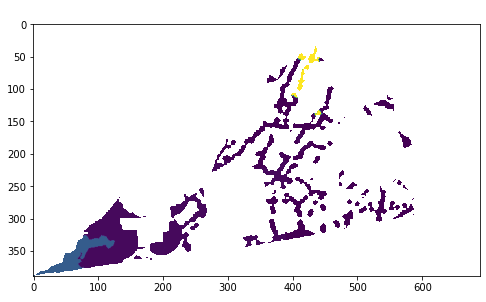

In [22]:
# plot conventional coal NLC with suitability for the target region
plot_array(nlc_mask[3, :, :])


`zones_arr`:  a 1D array of each LMP zone associated with each grid cell in the target region

In [14]:
zones_arr

array([ 1,  1,  1, ..., 37, 37, 37], dtype=uint8)

`xcoords`: a 1D array of X coordinates for the target grid

In [15]:
xcoords

array([1090947.1645, 1091947.1645, 1092947.1645, ..., 1776947.1645,
       1777947.1645, 1778947.1645])

`ycoords`: a 1D array of Y coordinates for the target grid

In [16]:
ycoords

array([358434.7995, 358434.7995, 358434.7995, ..., -29565.2005,
       -29565.2005, -29565.2005])

`indices_flat`: a 1D array of grid indices for the target region as they occur in the full CONUS extent

In [17]:
indices_flat

array([5874439, 5874440, 5874441, ..., 7696009, 7696010, 7696011])

## Start code

### Stage data for processing

In [23]:
# net locational costs with suitability mask for the target region
nlc_mask_shape = nlc_mask.shape

nlc_mask_shape


(12, 389, 689)

In [24]:
# set random seed so that we can reproduce any random process
np.random.seed(seed_value)


In [25]:
# number of technologies
n_techs = len(technology_order)

# dictionary to hold sited information
sited_dict = {'region_name': [],
                'tech_id': [],
                'tech_name': [],
                'unit_size_mw': [],
                'xcoord': [],
                'ycoord': [],
                'index': [],
                'buffer_in_km': [],
                'sited_year': [],
                'retirement_year': [],
                'lmp_zone': [],
                'locational_marginal_pricing': [],
                'net_operational_value': [],
                'interconnection_cost': [],
                'net_locational_cost': []}


In [26]:
technology_order

[0, 2, 4, 8, 9, 13, 14, 15, 16, 17, 18]

In [27]:
# show the expansion plan and tech specifics
for index, i in enumerate(expansion_dict.keys(), 0):
    if expansion_dict[i]['n_sites'] > 0:
        print(f"index: {index}, tech_id: {i}, {expansion_dict[i]['tech_name']}, n_sites: {expansion_dict[i]['n_sites']}")


index: 2, tech_id: 4, coal_conv_pul_wo_ccs, n_sites: 4
index: 3, tech_id: 9, gas_cc_w_ccs, n_sites: 22
index: 4, tech_id: 8, gas_cc_wo_ccs, n_sites: 8
index: 5, tech_id: 13, nuclear_gen_ii, n_sites: 2
index: 7, tech_id: 15, oil_ct_wo_ccs, n_sites: 2
index: 9, tech_id: 17, solar_pv_non_dist, n_sites: 11


In [28]:
# mask any technologies having 0 expected sites in the expansion plan to exclude them from competition
for index, i in enumerate(technology_order, 1):
        
    if expansion_dict[i]["n_sites"] == 0:
        nlc_mask[index, :, :] = np.ma.masked_array(nlc_mask[index, :, :], np.ones_like(nlc_mask[index, :, :]))


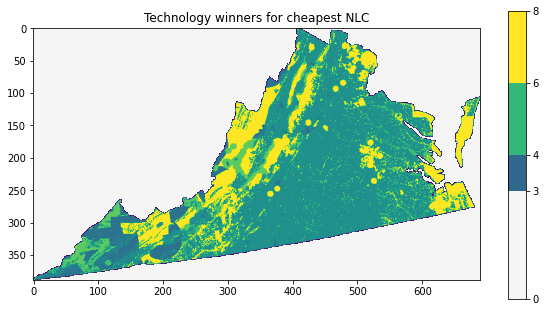

In [32]:
# show cheapest option, add 1 to the index to represent the technology number
cheapest_arr = np.argmin(nlc_mask, axis=0)

plot_array_wbar(cheapest_arr, "Technology winners for cheapest NLC")


For the cheapest NLC grid cells above, view the technologies that won and their accompanying expansion:

In [33]:
for i in np.unique(cheapest_arr):
    if i > 0:
        print(f"index: {i}, tech_name: {ref_dict[i][1]}, n_sites: {expansion_dict[ref_dict[i][0]]['n_sites']}")


index: 3, tech_name: coal_conv_pul_wo_ccs, n_sites: 4
index: 4, tech_name: gas_cc_wo_ccs, n_sites: 8
index: 6, tech_name: nuclear_gen_ii, n_sites: 2
index: 8, tech_name: oil_ct_wo_ccs, n_sites: 2


NOTE:  There were technologies that require sites in the expansion plan but were not reflected in the NLC winners above.  These will be sited in a subsequent iteration.

In [34]:
# flatten cheapest array to be able to use random
cheapest_arr_1d = cheapest_arr.flatten()

# prep array to hold outputs where 0 is the null technology
sited_arr_1d = np.zeros_like(cheapest_arr_1d)


In [35]:
# set initial value to for available grid cells to site in
avail_grids = np.where(cheapest_arr_1d > 0)[0].shape[0]

print(f"Number of available grid cells to site in:  {avail_grids}")


Number of available grid cells to site in:  103324


In [36]:
# create dictionary of {tech_id: flat_nlc_array, ...} ordered by the technology order
nlc_flat_dict = {i: nlc_mask[ix+1, :, :].flatten() for ix, i in enumerate(technology_order)}

nlc_flat_dict


{0: masked_array(data=[--, --, --, ..., --, --, --],
              mask=[ True,  True,  True, ...,  True,  True,  True],
        fill_value=1e+20,
             dtype=float64),
 2: masked_array(data=[--, --, --, ..., --, --, --],
              mask=[ True,  True,  True, ...,  True,  True,  True],
        fill_value=1e+20,
             dtype=float64),
 4: masked_array(data=[--, --, --, ..., --, --, --],
              mask=[ True,  True,  True, ...,  True,  True,  True],
        fill_value=1e+20),
 8: masked_array(data=[--, --, --, ..., --, --, --],
              mask=[ True,  True,  True, ...,  True,  True,  True],
        fill_value=1e+20),
 9: masked_array(data=[--, --, --, ..., --, --, --],
              mask=[ True,  True,  True, ...,  True,  True,  True],
        fill_value=1e+20),
 13: masked_array(data=[--, --, --, ..., --, --, --],
              mask=[ True,  True,  True, ...,  True,  True,  True],
        fill_value=1e+20),
 14: masked_array(data=[--, --, --, ..., --, --, --],
 

In [37]:
technology_order

[0, 2, 4, 8, 9, 13, 14, 15, 16, 17, 18]

## Competition algorithm

In [38]:
keep_siting = True

-- **START while loop 1**

This while loop processes each technology in the technology order loop over and over until the competition satisfies the expansion plan or until there are no more suitable grid cells left to site in.

```python
while keep_siting:
```

-- **START for loop 1**

```python
    for index, tech_id in enumerate(technology_order):
```

In [39]:
index = 3
tech_id = technology_order[index]

tech_id


8

In [40]:
# assign an index as it appears in the n-dim array to the order in which it is being processed
#  index of 0 is the default array and does not represent a technology
tech_index = index + 1


In [41]:
# get the indices of the target tech ids where the target tech is the cheapest option
tech = np.where(cheapest_arr_1d == tech_index)[0]

tech


array([  1097,   1786,   1787, ..., 266650, 266654, 267335])

In [42]:
# the number of sites for the target tech
required_sites = expansion_dict[tech_id]['n_sites']

required_sites


8

In [43]:
# calculate the year of retirement
retirement_year = settings_dict['run_year'] + int(technology_dict[tech_id]['lifetime'])

retirement_year


2075

-- **START Condition 1**

If there are more power plants to site and there are grids available to site them

```python
if self.avail_grids > 0 and tech.shape[0] > 0 and required_sites > 0:
```

In [44]:
# if there are more power plants to site and there are grids available to site them...
avail_grids > 0, tech.shape[0] > 0, required_sites > 0


(True, True, True)

In [45]:
still_siting = True
sited_list = []

-- **START Sub while loop**

While we are still able to site power plants...

```python
while still_siting:
```

In [46]:
# get the NLC values associated with each winner
tech_nlc = nlc_flat_dict[tech_id][tech]

tech_nlc


masked_array(data=[-12228024735.435358, -12228022244.202732,
                   -12228012498.188715, ..., -14254128487.298212,
                   -14254141578.375334, -14254131245.133755],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [47]:
# get the least expensive NLC indices from the winners
tech_nlc_cheap = tech[np.where(tech_nlc == np.nanmin(tech_nlc))]

tech_nlc_cheap


array([78532])

In [48]:
# select a random index that has a winning cell for the check where multiple low NLC may exists
target_ix = np.random.choice(tech_nlc_cheap)

target_ix


78532

In [49]:
# add selected index to sited dictionary
sited_dict['region_name'].append(target_region_name)
sited_dict['tech_id'].append(tech_id)
sited_dict['tech_name'].append(technology_dict[tech_id]['tech_name'])
sited_dict['unit_size_mw'].append(technology_dict[tech_id]['unit_size'])
sited_dict['xcoord'].append(xcoords[target_ix])
sited_dict['ycoord'].append(ycoords[target_ix])
sited_dict['index'].append(indices_flat[target_ix])
sited_dict['buffer_in_km'].append(technology_dict[tech_id]['buffer_in_km'])
sited_dict['sited_year'].append(settings_dict['run_year'])
sited_dict['retirement_year'].append(retirement_year)
sited_dict['lmp_zone'].append(zones_flat_arr[target_ix])
sited_dict['locational_marginal_pricing'].append(lmp_flat_dict[tech_id][target_ix])
sited_dict['net_operational_value'].append(nov_flat_dict[tech_id][target_ix])
sited_dict['interconnection_cost'].append(ic_flat_dict[tech_id][target_ix])
sited_dict['net_locational_cost'].append(nlc_flat_dict[tech_id][target_ix])

sited_dict


{'region_name': ['virginia'],
 'tech_id': [8],
 'tech_name': ['gas_cc_wo_ccs'],
 'unit_size_mw': [400],
 'xcoord': [1765947.1645],
 'ycoord': [245434.79949999996],
 'index': [6405423],
 'buffer_in_km': [5],
 'sited_year': [2030],
 'retirement_year': [2075],
 'lmp_zone': [30],
 'locational_marginal_pricing': [315.9335188238149],
 'net_operational_value': [16778245375.421497],
 'interconnection_cost': [1760183.7049540116],
 'net_locational_cost': [-16776485191.716543]}

In [50]:
# add selected index to list
sited_list.append(target_ix)

sited_list


[78532]

In [51]:
# apply buffer
result = buffer_flat_array(target_index=target_ix,
                            arr=cheapest_arr_1d,
                            nrows=cheapest_arr.shape[0],
                            ncols=cheapest_arr.shape[1],
                            ncells=technology_dict[tech_id]['buffer_in_km'],
                            set_value=0)

# unpack values
cheapest_arr_1d, buffer_indices_list = result


In this case, the buffer was 5km around the kernel which would exclude 11 * 11 or 121 grid cells when accounting for an unimpeded buffer range (away from borders)

In [52]:
len(buffer_indices_list)

121

In [53]:
# update the number of sites left to site
required_sites -= 1

expansion_dict[tech_id].update(n_sites=required_sites)

required_sites


7

In [54]:
# get the tech indices where they were the cheapest option and remove any buffered grid cells from the array
tech_indices_to_delete = [np.where(tech == i)[0][0] for i in buffer_indices_list if i in tech]

# remove any buffered elements as an option to site
tech = np.delete(tech, tech_indices_to_delete)


In [55]:
len(tech_indices_to_delete)

45

**-- START Subcondition 1**

Exit siting for the target technology if all sites have been sited or if there are no more winning cells

```python
if required_sites == 0 or tech.shape[0] == 0:
    still_siting = False
```


In [56]:
required_sites == 0 or tech.shape[0] == 0

False

In [ ]:
still_siting = False

-- **END Subcondition 1**

-- **END Sub while loop**

In [57]:
# array of the site indices
rdx = np.array(sited_list)

rdx


array([78532])

In [58]:
# add sited tech_ids to output array
sited_arr_1d[rdx] = tech_id


Update original array with excluded area where siting occurred

-- **START Subcondition 2**

If target technology has no more sites to be sited make all elements for the target tech in the NLC mask unsuitable so we can progress

```python
if self.expansion_dict[tech_id] == 0:
```

In [59]:

expansion_dict[tech_id] == 0

False

In [ ]:
# make all elements for the target tech in the NLC mask unsuitable so we can progress
nlc_mask[tech_index, :, :] = np.ma.masked_array(self.nlc_mask[0, :, :], np.ones_like(self.nlc_mask[0, :, :]))


-- **END Subcondition 2**

Apply the new exclusion for sited area from the current technology to all techs...
 - invert sited elements to have a value of 1 so they can be used as a mask
 - repeat the new sited array to create a mask for all techs and reshape to 2D
 - update all technologies with the new mask
 

In [60]:
nlc_mask[1:, :, :] = np.ma.masked_array(nlc_mask[1:, :, :],
                                        np.tile(np.where(cheapest_arr_1d == 0, 1, 0),
                                                nlc_mask_shape[0] - 1).reshape(
                                                 (nlc_mask_shape[0] - 1,
                                                  nlc_mask_shape[1],
                                                  nlc_mask_shape[2])))


-- **START Subcondition 3**

If the technology has achieved its full expansion, then mask the rest of its suitable area so other technologies can now compete for the grid cells it previously won but now no longer needs

```python
if self.expansion_dict[tech_id]['n_sites'] == 0:
```


In [61]:
expansion_dict[tech_id]['n_sites'] == 0

False

In [66]:
nlc_mask[tech_index, :, :] = np.ma.masked_array(nlc_mask[tech_index, :, :], np.ones_like(nlc_mask[tech_index, :, :]))


-- **END Subcondition 3**

Recalculate the cheapest technology option per grid cell

In [62]:
# show cheapest option, add 1 to the index to represent the technology number
cheapest_arr = np.argmin(nlc_mask, axis=0)


In [63]:
# flatten cheapest array to be able to use random
cheapest_arr_1d = cheapest_arr.flatten()


In [64]:
# check for any available grids to site in
avail_grids = np.where(cheapest_arr_1d > 0)[0].shape[0]

avail_grids


103243

In [65]:
# are there any sites left to site
left_to_site = sum([expansion_dict[i]['n_sites'] for i in expansion_dict.keys()])

left_to_site


48

-- **START Subcondition 4**

Stop technology iteration if all area is consumed or if all sites have been sited

```python
if self.avail_grids == 0 or left_to_site == 0:
```

In [66]:
avail_grids == 0 or left_to_site == 0

False

In [ ]:
keep_siting = False

-- **END Subcondition 4**

-- **START Condition 2**

```python 
# there are no more suitable grid cells
elif self.avail_grids == 0:
    keep_siting = False
```


In [32]:
avail_grids == 0

False

In [ ]:
keep_siting = False


-- **END Condition 2**

-- **START Condition 3**

```python
# if there are available grids and a cheapest option available but no more required sites
elif self.avail_grids > 0 and tech.shape[0] > 0 and required_sites == 0:
```

In [33]:
avail_grids > 0, tech.shape[0] > 0, required_sites == 0

(True, False, True)

If there are no required sites, then mask the rest of the techs suitable area so other technologies can now compete for the grid cells it previously won but now no longer needs

In [ ]:
nlc_mask[tech_index, :, :] = np.ma.masked_array(nlc_mask[tech_index, :, :], np.ones_like(nlc_mask[tech_index, :, :]))


In [ ]:
# show cheapest option, add 1 to the index to represent the technology number
cheapest_arr = np.argmin(nlc_mask, axis=0)


In [ ]:
# flatten cheapest array to be able to use random
cheapest_arr_1d = cheapest_arr.flatten()


In [ ]:
# check for any available grids to site in
avail_grids = np.where(cheapest_arr_1d > 0)[0].shape[0]


-- **END Condition 3**

####  **NOTE**:  there is no resolving condition.  Need to add this in

At the end of any condition a data frame is created...

NOTE:  I believe this should only happen at the end, not in each iteration

In [67]:
sited_dtypes = {'region_name': str,
                'tech_id': np.int64,
                'tech_name': str,
                'unit_size_mw': np.float64,
                'xcoord': np.float64,
                'ycoord': np.float64,
                'lmp_zone': np.int64,
                'locational_marginal_pricing': np.float64,
                'net_operational_value': np.float64,
                'interconnection_cost': np.float64,
                'net_locational_cost': np.float64,
                'index': np.int64,
                'retirement_year': np.int64,
                'sited_year': np.int64,
                'buffer_in_km': np.int64}

# create sited data frame
df = pd.DataFrame(sited_dict).astype(sited_dtypes)

df


,region_name,tech_id,tech_name,unit_size_mw,xcoord,ycoord,index,buffer_in_km,sited_year,retirement_year,lmp_zone,locational_marginal_pricing,net_operational_value,interconnection_cost,net_locational_cost
0,virginia,8,gas_cc_wo_ccs,400.0,1.765947e+06,245434.7995,6405423,5,2030,2075,30,315.933519,1.677825e+10,1.760184e+06,-1.677649e+10


-- **END for loop**

-- **END while loop**

The following 2D array along with the data frame for sited power plants will be returned.

NOTE:  the power plants are hard to distinguish in the image below because of the scale; look for the tiny dots in the northeast portion

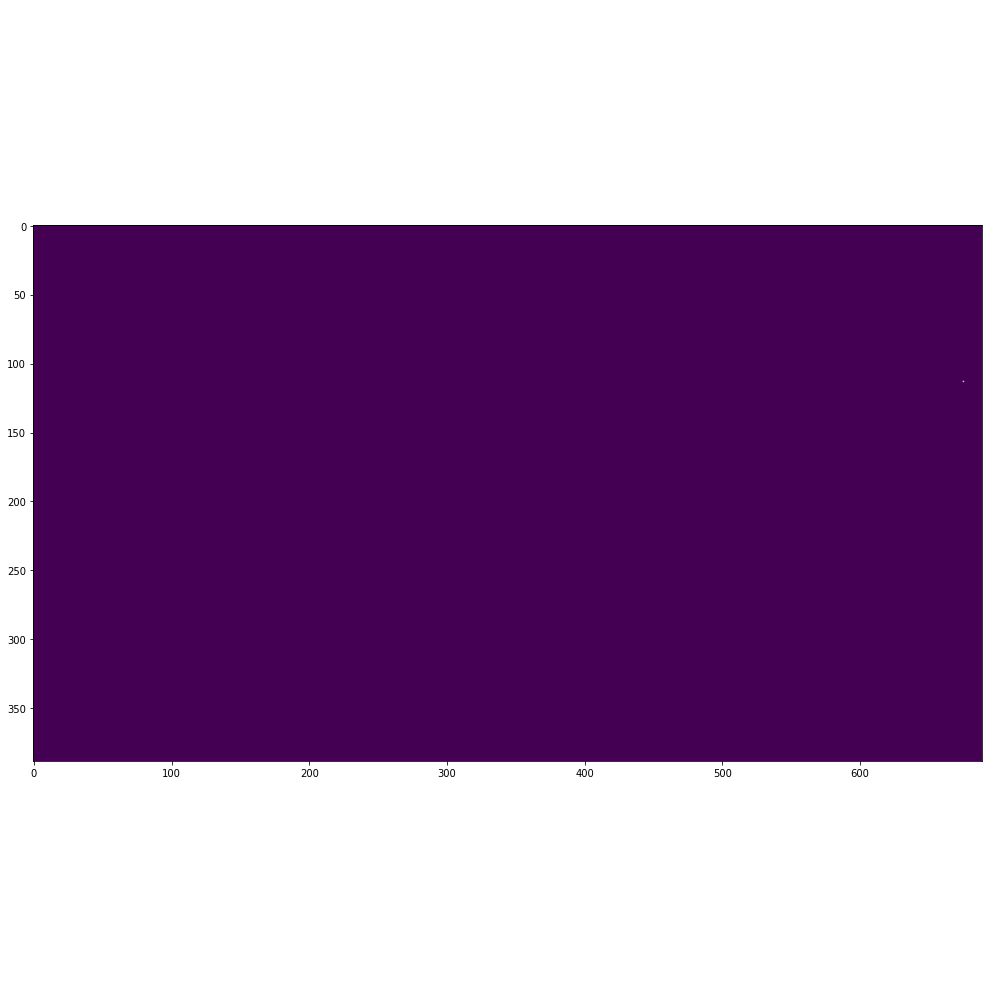

In [76]:
plot_array(sited_arr_1d.reshape(cheapest_arr.shape), figsize=(17, 17))